In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from EDMtoolkit import *

In [2]:
# filename = "../Datasets/newport/EnvData_for_Copepod_Cladoceran_Oikopleura_densities_NH05_1996-present.csv"
# data_env = pd.read_csv(filename)

In [3]:
filename = "../Datasets/newport/Copepod_Cladoceran_Oikopleura_densities_NH05_1996-present.csv"
data = pd.read_csv(filename, encoding="utf-8")

In [4]:
data.head()

,StationCode,NetType,SampleDate,Station,GenusSpecies,LifeHistoryStage,TaxaGrouping,NRows,Sum(Density (#/m3)
0,052196NH05,vertical,05/21/1996,NH05,ACARTIA TONSA,"Female, Adult",Copepod_Southern,1,4.329197
1,052196NH05,vertical,05/21/1996,NH05,CALANUS PACIFICUS,"1, CI",Copepod_Southern,1,43.291966
2,052196NH05,vertical,05/21/1996,NH05,CALANUS PACIFICUS,"2, CII",Copepod_Southern,1,17.316786
3,052196NH05,vertical,05/21/1996,NH05,CALANUS PACIFICUS,"3, CIII",Copepod_Southern,1,34.633573
4,052196NH05,vertical,05/21/1996,NH05,CALANUS PACIFICUS,"4, CIV",Copepod_Southern,1,4.329197


In [5]:
data[["GenusSpecies","LifeHistoryStage","TaxaGrouping"]].drop_duplicates().to_csv("Newport_All_Species_Functional_Groups.csv")

In [6]:
# first we construct the t time series since it is identical for all species
dates = [(datetime.strptime(m, "%m/%d/%Y")).date() for m in data["SampleDate"].unique()]
months = [m.date() for m in pd.date_range("1996-5-1","2022-4-1", freq='MS')]

# Must create a null time series which is 0 during all months
# where there was at least one observation and NULL otherwise
time_series_default = np.array([0 if np.any([date.year == month.year and date.month == month.month for date in dates])
                         else np.nan 
                         for month in months])

# days = np.zeros(dates.shape[0])
# date0 = (datetime.strptime(dates[0], "%m/%d/%Y")).date()

"""
j = 0
for i, date_string in enumerate(dates):
    new_date = (datetime.strptime(date_string, "%m/%d/%Y")).date()
    days[i] = (new_date - date0).days

t = (days - np.min(days)) / np.ptp(days)
n_years = np.ptp(days) / 365
"""

n_years = (months[-1] - months[0]).days / 365
t = np.linspace(0,1,num=len(months))

In [7]:
"""
figd, axd = plt.subplots(1)
axd.plot(days[1:] - days[:-1])
axd.set_xlabel("Sample Number")
axd.set_ylabel("Difference in Days")

plt.show()
"""

'\nfigd, axd = plt.subplots(1)\naxd.plot(days[1:] - days[:-1])\naxd.set_xlabel("Sample Number")\naxd.set_ylabel("Difference in Days")\n\nplt.show()\n'

In [8]:
"""
figd, axd = plt.subplots(1)
axd.plot(days[1:] - days[:-1])
axd.set_xlabel("Sample Number")
axd.set_ylabel("Difference in Days")

plt.show()
"""

'\nfigd, axd = plt.subplots(1)\naxd.plot(days[1:] - days[:-1])\naxd.set_xlabel("Sample Number")\naxd.set_ylabel("Difference in Days")\n\nplt.show()\n'

In [9]:
def get_species_series(species_name, life_history_stage):
    
    species_df = data.query('GenusSpecies == ["{}"] and LifeHistoryStage == ["{}"]'.format(species_name, life_history_stage))
    species_dates = [(datetime.strptime(m, "%m/%d/%Y")).date() for m in species_df["SampleDate"].to_numpy()]
    species_abundances = species_df["Sum(Density (#/m3)"].to_numpy()
    
    ts = time_series_default.copy()
    
    for i in range(ts.shape[0]):
        month = months[i]
        valid_species = np.array([date.year == month.year and date.month == month.month for date in species_dates])
        
        if np.any(valid_species):
            abundance = np.mean(species_abundances[valid_species])
            ts[i] = abundance
        
    
    """
    species_df = data.query('GenusSpecies == ["{}"] and LifeHistoryStage == ["{}"]'.format(species_name, life_history_stage))
    
    dates = data["SampleDate"].unique()
    is_present = np.isin(dates,species_df["SampleDate"].to_numpy())
    time_series = np.zeros(dates.shape[0])
    
    species_abundances = species_df["Sum(Density (#/m3)"].to_numpy()
    j = 0
    
    for i in range(dates.shape[0]):
        if is_present[i]:
            time_series[i] = species_abundances[j]
            j += 1
    """
    
    """
    time_series = species_df["Sum(Density (#/m3)"].to_numpy()
    
    dates = data["SampleDate"].unique()
    time_series = np.zeros(dates.shape[0])
    
    for t in range(time_series.shape[0]):
        
        time_series[t] = 0
    """
    
    return ts

In [10]:
newport_species_fg = np.array(["",""])
newport_w_s_r2 = np.zeros(2)

In [11]:
mean_abundance = np.zeros(1)
species_names = np.array(["1", "1","1"])

for species_name in np.unique(data["GenusSpecies"].to_numpy()):
    functional_groups = np.unique(data.query("GenusSpecies == ['{}']".format(species_name))["LifeHistoryStage"])
    for fg in functional_groups:
        X = get_species_series(species_name, fg)
        north_south = data.query("GenusSpecies == ['{}']".format(species_name))["TaxaGrouping"].to_numpy()[0]
        
        mean_abundance = np.vstack([mean_abundance, np.array([np.mean(X[np.isfinite(X)])])])
        species_names = np.vstack([species_names,np.array([species_name, fg, north_south])])
        # print(f"{species_name} {fg} {t.shape[0]} {north_south}")
        # print(f"{np.mean(X)} {north_south} {species_name} {fg}")
        
mean_abundance = mean_abundance[1:]
species_names = species_names[1:]

In [12]:
northern_raw = np.zeros(312)
southern_raw = np.zeros(312)

for species_name in np.unique(data["GenusSpecies"].to_numpy()):
    functional_groups = np.unique(data.query("GenusSpecies == ['{}']".format(species_name))["LifeHistoryStage"])
    for fg in functional_groups:
        X = get_species_series(species_name, fg)
        north_south = data.query("GenusSpecies == ['{}']".format(species_name))["TaxaGrouping"].to_numpy()[0]
        
        if north_south == "Copepod_Northern":
            northern_raw += X
        else:
            southern_raw += X

In [13]:
northern = standardize(np.sqrt(northern_raw))
southern = standardize(np.sqrt(southern_raw))

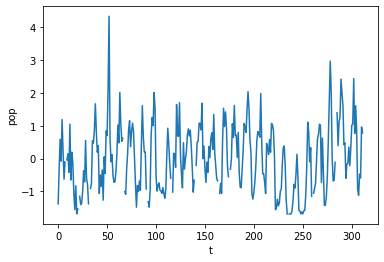

In [14]:
plotTS(northern)

In [37]:
northern.shape

(312,)

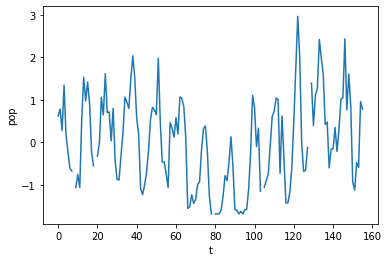

In [45]:
plotTS(northern[156:])

In [18]:
tau = find_tau_autocorr(northern[:])

# A,B = delayEmbed(northern,5,0,0)
# np.corrcoef(A.flatten(), B.flatten())[0,1]

1.0
0.618840090365466
0.3722156873294641
0.13599022039536346
-0.1384366529489158


In [43]:
delta_agg, theta_agg, r_sqrd = get_delta_agg(northern[:156], 3, tau=4, horizon=1, return_forecast_skill=True)

In [44]:
print(f"delta = {delta_agg:.3}, theta = {theta_agg:.3}, r2 = {r_sqrd:.3}, stationary window = {n_years / np.sqrt(delta_agg):.3}")

delta = 0.0, theta = 0.00713, r2 = 0.379, stationary window = inf


c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


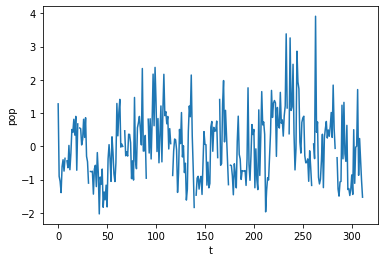

In [49]:
plotTS(southern)

In [50]:
delta_agg, theta_agg, r_sqrd = get_delta_agg(southern, 4, tau=4, horizon=1, return_forecast_skill=True)

In [51]:
print(f"delta = {delta_agg:.3}, theta = {theta_agg:.3}, r2 = {r_sqrd:.3}, stationary window = {n_years / np.sqrt(delta_agg):.3}")

delta = 0.369, theta = 0.151, r2 = 0.165, stationary window = 42.7


Below we determine the most abundance 

In [52]:
top_species = species_names[np.flip(mean_abundance.flatten().argsort())]

In [69]:
fg_species_life_stage = pd.read_csv("Newport_All_Species_Functional_Groups_2.csv",encoding="utf-8").to_numpy()[:,1:]

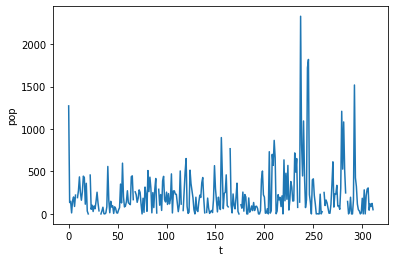

In [54]:
i=2
plotTS(get_species_series(top_species[i,0],top_species[i,1]))

5


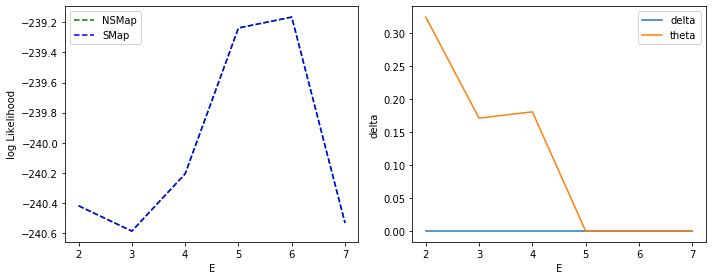

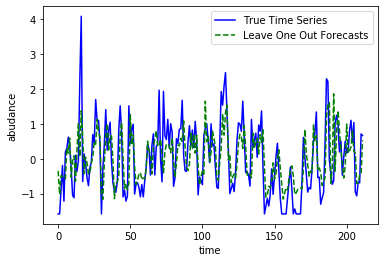

PSEUDOCALANUS 5, CV, delta = 0.000, theta = 0.113 r^2 = 0.424
5


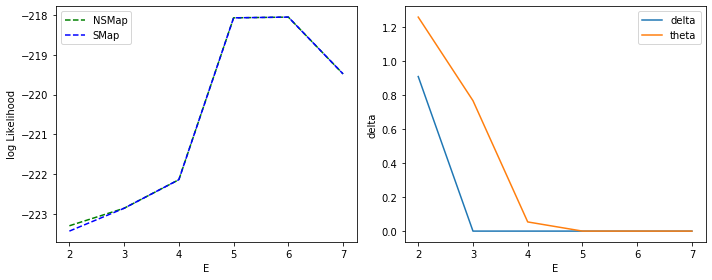

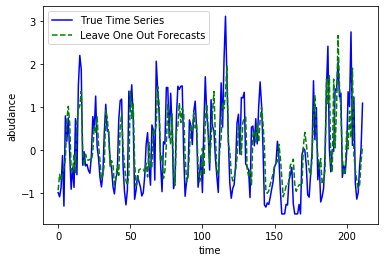

PSEUDOCALANUS Female, Adult, delta = 0.169, theta = 0.368 r^2 = 0.508
14


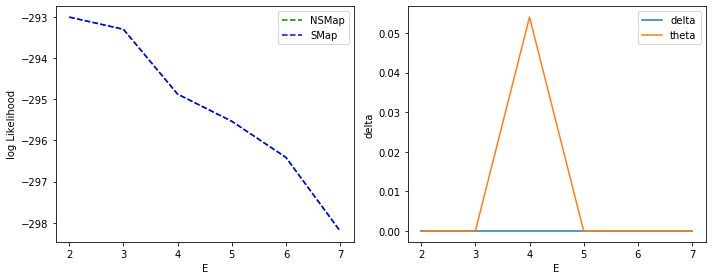

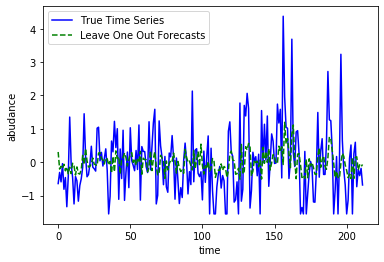

OIKOPLEURA Unknown, delta = 0.000, theta = 0.009 r^2 = 0.073
5


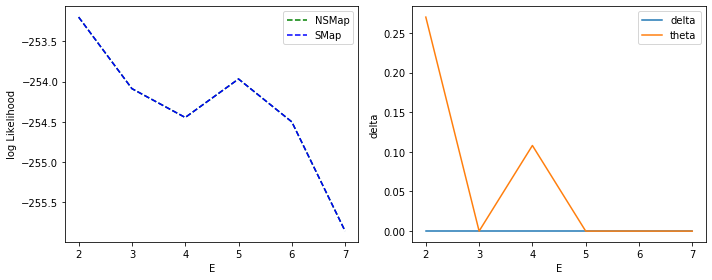

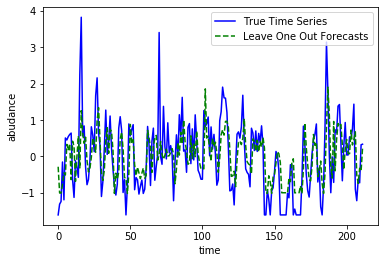

PSEUDOCALANUS 4, CIV, delta = 0.000, theta = 0.063 r^2 = 0.351
4


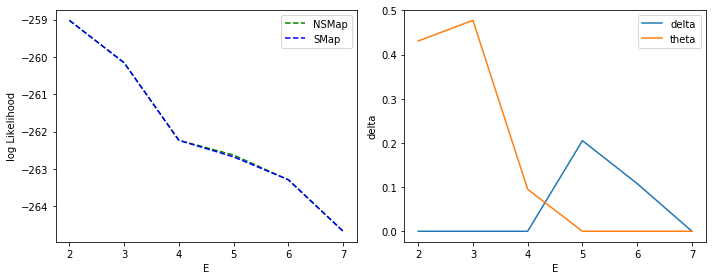

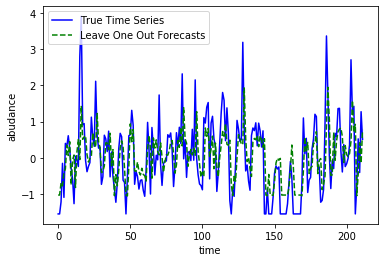

PSEUDOCALANUS 3, CIII, delta = 0.053, theta = 0.166 r^2 = 0.355
5


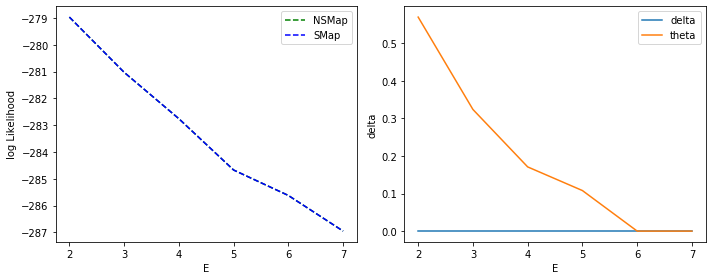

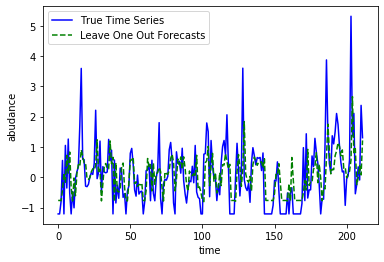

PSEUDOCALANUS 2, CII, delta = 0.000, theta = 0.196 r^2 = 0.255
18


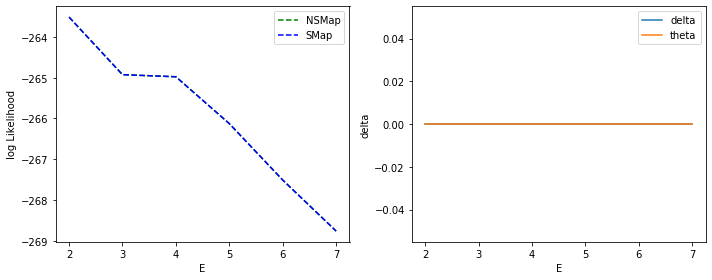

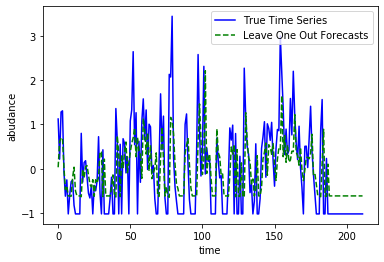

PARACALANUS PARVUS Copepodite, delta = 0.000, theta = 0.000 r^2 = 0.297
4


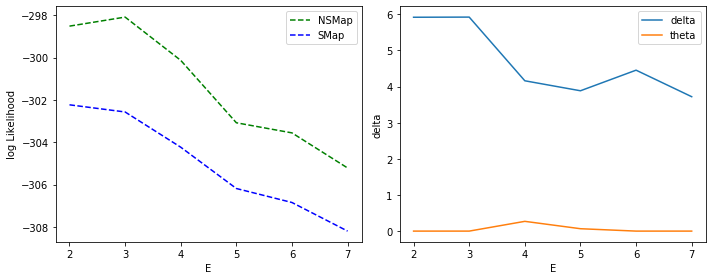

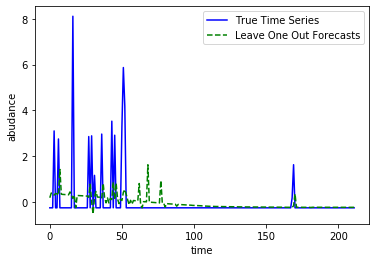

PSEUDOCALANUS Copepodite, delta = 5.015, theta = 0.069 r^2 = 0.038
4


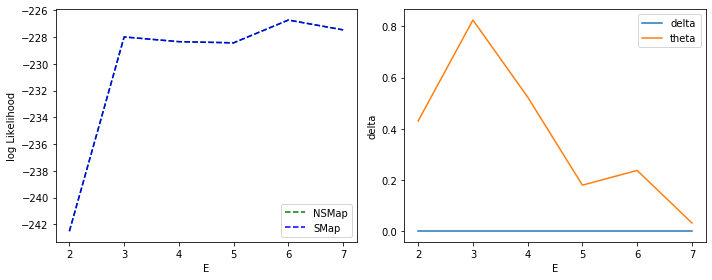

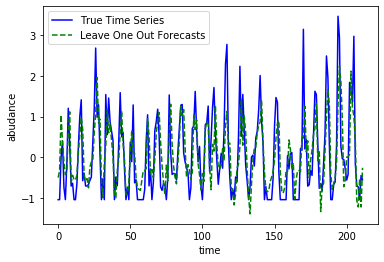

ACARTIA LONGIREMIS Female, Adult, delta = 0.000, theta = 0.372 r^2 = 0.513
4


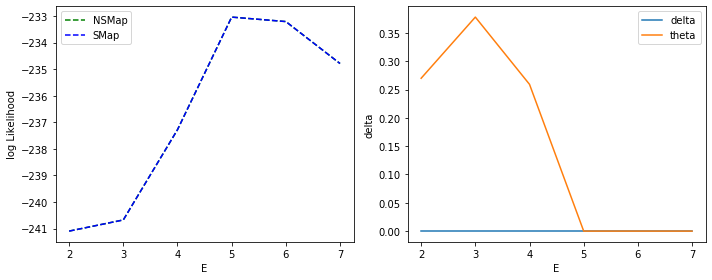

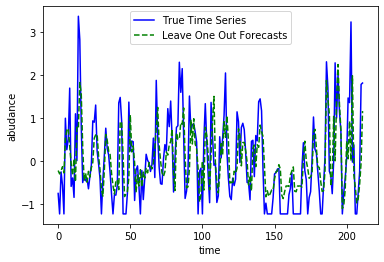

PSEUDOCALANUS Male, Adult, delta = 0.000, theta = 0.151 r^2 = 0.420


In [37]:
newport_species_fg = np.array(["1","1"])
newport_w_s_r2 = np.zeros(3)

for species_name, fg, _ in top_species[:10]:
    X = get_species_series(species_name, fg)
    Xr = standardize(np.sqrt(X[:,None]))
    
    # plotTS(Xr, title=species_name + " " + fg)
    # print(find_tau_autocorr(Xr))
    
    try: 
        delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, 5, t=t,tau=4, return_forecast_skill=True)
    except:
        print("Too many 0s to do linear algebra")
        continue

    newport_species_fg = np.vstack([newport_species_fg, np.array([species_name, fg])])
    newport_w_s_r2 = np.vstack([newport_w_s_r2, np.array([delta_agg, theta_agg, r_sqrd])])

    print(f"{species_name} {fg}, delta = {delta_agg:.3f}, theta = {theta_agg:.3f} r^2 = {r_sqrd:.3f}")

In [36]:
for species_name, fg, _ in top_species[:5]:
    X = get_species_series(species_name, fg)
    Xr = standardize(np.sqrt(X[:,None]))
    
    # plotTS(Xr, title=species_name + " " + fg)
    print(find_tau_autocorr(Xr))
    

5
5
14
5
4


In [25]:
# np.savetxt("newport_sp`ecies_fg.txt", newport_species_fg, fmt=["%s;","%s"])
# np.savetxt("newport_w_s_r2.txt", newport_w_s_r2, delimiter=",")

In [26]:
newport_w_s_r2 = np.loadtxt("newport_w_s_r2.txt", delimiter=",")
newport_species_fg = np.loadtxt("newport_species_fg.txt", delimiter=";", dtype=str)

([array([1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 array([  0.20944025,  12.34943499,  24.48942973,  36.62942447,
         48.76941921,  60.90941394,  73.04940868,  85.18940342,
         97.32939816, 109.4693929 , 121.60938764]),
 <a list of 2 Lists of Patches objects>)

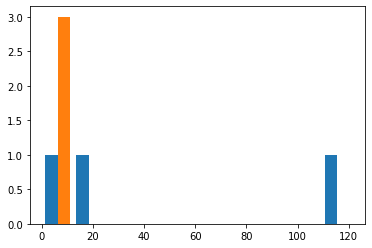

In [27]:
plt.hist(newport_w_s_r2[np.logical_and(newport_w_s_r2[:,1] > 0.2, np.isfinite(newport_w_s_r2[:,0]))])

In [28]:
np.mean(np.isfinite(newport_w_s_r2[newport_w_s_r2[:,1] > 0.2][:,0]))

0.6

In [29]:
for species, genus, w_s, r_sqrd in np.hstack([newport_species_fg, newport_w_s_r2]):
    print(f"{species} {genus}, w_s = {float(w_s):.3f}, r^2 = {float(r_sqrd):.3f}")

ACARTIA LONGIREMIS  Copepodite, w_s = inf, r^2 = 0.042
ACARTIA LONGIREMIS  Female, Adult, w_s = 18.084, r^2 = 0.209
ACARTIA LONGIREMIS  Male, Adult, w_s = 121.609, r^2 = 0.237
ACARTIA TONSA  Copepodite, w_s = 11.694, r^2 = 0.091
ACARTIA TONSA  Female, Adult, w_s = 65.672, r^2 = 0.014
ACARTIA TONSA  Male, Adult, w_s = inf, r^2 = 0.000
CALANUS MARSHALLAE  1, CI, w_s = inf, r^2 = 0.007
CALANUS MARSHALLAE  2, CII, w_s = 203.735, r^2 = 0.013
CALANUS MARSHALLAE  3, CIII, w_s = inf, r^2 = 0.014
CALANUS MARSHALLAE  4, CIV, w_s = inf, r^2 = 0.005
CALANUS MARSHALLAE  5, CV, w_s = inf, r^2 = 0.037
CALANUS MARSHALLAE  Female, Adult, w_s = 22.628, r^2 = 0.048
CALANUS PACIFICUS  1, CI, w_s = inf, r^2 = 0.153
CALANUS PACIFICUS  2, CII, w_s = 40.468, r^2 = 0.000
CALANUS PACIFICUS  3, CIII, w_s = inf, r^2 = 0.286
CALANUS PACIFICUS  4, CIV, w_s = 35.670, r^2 = 0.012
CALANUS PACIFICUS  5, CV, w_s = 139.259, r^2 = 0.004
CALANUS PACIFICUS  Female, Adult, w_s = 17.705, r^2 = 0.131
CALOCALANUS  Female, Adult

In [30]:
datetime.strptime(data["Sample Date"].to_numpy()[0], "%m/%d/%Y").timetuple().tm_yday

KeyError: 'Sample Date'

In [ ]:
data.query("Genus Species == ")

In [ ]:
anomaly_file = "../Datasets/cciea_EI_COP_cleaned.csv"

southern_TS = pd.read_csv(anomaly_file).query("timeseries==['SouthernBiomassAnomaly']")["index"].to_numpy()
northern_TS = pd.read_csv(anomaly_file).query("timeseries==['NorthernBiomassAnomaly']")["index"].to_numpy()

In [ ]:
plotTS(southern_TS)

In [ ]:
plotTS(northern_TS)

In [ ]:
t = np.linspace(0,1,num=northern_TS.shape[0])

In [ ]:
delta_agg_n, theta_n, r_sqrd_n = get_delta_agg(northern_TS, 10, t=t, return_forecast_skill=True)
delta_agg_s, theta_s, r_sqrd_s = get_delta_agg(southern_TS, 10, t=t, return_forecast_skill=True)

In [ ]:
delta_agg_s

In [ ]:
r_sqrd_s

In [ ]:
# I'm going to try to reconstruct the detrended data

data.query("TaxaGrouping == ['Copepod_Southern']")

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
sorted_indices = np.flip(newport_w_s_r2[:,1].argsort())
newport_w_s_r2[sorted_indices]
newport_species_fg[sorted_indices]

In [31]:
for sp, fg, des in top_species:
    print(f"{sp}\t\t{fg}\t\t{des}")

PSEUDOCALANUS		5, CV		Copepod_Northern
PSEUDOCALANUS		Female, Adult		Copepod_Northern
OIKOPLEURA		Unknown		Apendicularian
PSEUDOCALANUS		4, CIV		Copepod_Northern
PSEUDOCALANUS		3, CIII		Copepod_Northern
PSEUDOCALANUS		2, CII		Copepod_Northern
PARACALANUS PARVUS		Copepodite		Copepod_Southern
PSEUDOCALANUS		Copepodite		Copepod_Northern
ACARTIA LONGIREMIS		Female, Adult		Copepod_Northern
PSEUDOCALANUS		Male, Adult		Copepod_Northern
ACARTIA LONGIREMIS		Male, Adult		Copepod_Northern
ACARTIA LONGIREMIS		Copepodite		Copepod_Northern
PARACALANUS PARVUS		Female, Adult		Copepod_Southern
PSEUDOCALANUS		1, CI		Copepod_Northern
CORYCAEUS ANGLICUS		Copepodite		Copepod_Southern
EVADNE		Unknown		Cladoceran
CENTROPAGES		Male, Adult		Copepod_other
CTENOCALANUS VANUS		Copepodite		Copepod_Southern
CENTROPAGES		5, CV		Copepod_other
CENTROPAGES		4, CIV		Copepod_other
CLAUSOCALANUS		Copepodite		Copepod_Southern
CALANUS MARSHALLAE		1, CI		Copepod_Northern
CENTROPAGES		Copepodite		Copepod_other
CENTROPAGES		Fe